In [1]:
# Cell 1
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import io
import os
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import random
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

In [2]:
# Cell 2
def upload_and_process_files(directory, num_files_to_use=None):
    svc_files = [f for f in os.listdir(directory) if f.endswith('.svc')]
    
    if num_files_to_use:
        svc_files = random.sample(svc_files, num_files_to_use)

    data_frames = []
    scalers = []

    num_files = len(svc_files)
    fig, axs = plt.subplots(1, num_files, figsize=(6*num_files, 6), constrained_layout=True)
    if num_files == 1:
        axs = [axs]

    for i, filename in enumerate(svc_files):
        file_path = os.path.join(directory, filename)
        df = pd.read_csv(file_path, skiprows=1, header=None, delim_whitespace=True)
        df.columns = ['x', 'y', 'timestamp', 'pen_status', 'pressure', 'azimuth', 'altitude']
        
        # Modify timestamp to start from 0
        df['timestamp'] = (df['timestamp'] - df['timestamp'].min()).round().astype(int)
        
        df = df.iloc[:, [0, 1, 2, 3]]  # Select x, y, timestamp, and pen_status
        data_frames.append(df)
        scaler = MinMaxScaler()
        normalized_data = scaler.fit_transform(df[['x', 'y', 'timestamp']])
        scalers.append(scaler)

        on_paper = df[df['pen_status'] == 1]
        in_air = df[df['pen_status'] == 0]
        axs[i].scatter(-on_paper['y'], on_paper['x'], c='blue', s=1, alpha=0.7, label='On Paper')
        axs[i].scatter(-in_air['y'], in_air['x'], c='red', s=1, alpha=0.7, label='In Air')
        axs[i].set_title(f'Original Data {i + 1}')
        axs[i].set_xlabel('-y')
        axs[i].set_ylabel('x')
        axs[i].legend()
        axs[i].set_aspect('equal')

        # Print the first few rows of the timestamp column
        print(f"Modified timestamps for file {filename}:")
        print(df['timestamp'].head())
        print("\n")

    plt.show()

    processed_data = [np.column_stack((scaler.transform(df[['x', 'y', 'timestamp']]), df['pen_status'].values)) 
                      for df, scaler in zip(data_frames, scalers)]
    avg_data_points = int(np.mean([df.shape[0] for df in data_frames]))

    return data_frames, processed_data, scalers, avg_data_points

directory = '../../uploads'  # Directory where the .svc files are stored
data_frames, processed_data, scalers, avg_data_points = upload_and_process_files(directory, num_files_to_use=1)
print(f"Number of processed files: {len(processed_data)}")
print(f"Average number of data points: {avg_data_points}")

FileNotFoundError: [WinError 3] The system cannot find the path specified: '../uploads'

In [4]:
# Cell 3 (modified)
class VAE(tf.keras.Model):
    def __init__(self, latent_dim, beta=1.0):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.beta = beta
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(7,)),  # Changed to 4 for x, y, timestamp, pen_status
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(latent_dim * 2)
        ])
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(4)  # Changed to 4 for x, y, timestamp, pen_status
        ])

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z):
        decoded = self.decoder(z)
        xy_timestamp = tf.sigmoid(decoded[:, :3])  # x, y, and timestamp
        pen_status = tf.sigmoid(decoded[:, 3])
        return tf.concat([xy_timestamp, tf.expand_dims(pen_status, -1)], axis=1)

    def call(self, inputs):
        mean, logvar = self.encode(inputs)
        z = self.reparameterize(mean, logvar)
        return self.decode(z), mean, logvar


# New: LSTM Discriminator for GAN
class LSTMDiscriminator(tf.keras.Model):
    def __init__(self):
        super(LSTMDiscriminator, self).__init__()
        self.model = Sequential()
        self.model.add(LSTM(64, return_sequences=True, input_shape=(None, 4)))  # LSTM for sequence learning
        self.model.add(LSTM(32))
        self.model.add(Dense(1, activation='sigmoid'))  # Binary classification

    def call(self, x):
        return self.model(x)

# Function to compute VAE loss
def compute_loss(model, x):
    x_reconstructed, mean, logvar = model(x)
    reconstruction_loss_xy_timestamp = tf.reduce_mean(tf.keras.losses.mse(x[:, :3], x_reconstructed[:, :3]))
    reconstruction_loss_pen = tf.reduce_mean(tf.keras.losses.binary_crossentropy(x[:, 3], x_reconstructed[:, 3]))
    kl_loss = -0.5 * tf.reduce_mean(1 + logvar - tf.square(mean) - tf.exp(logvar))
    return reconstruction_loss_xy_timestamp + reconstruction_loss_pen, kl_loss, model.beta * kl_loss


latent_dim = 64
beta = 0.000001
learning_rate = 0.001

vae = VAE(latent_dim, beta)
optimizer = tf.keras.optimizers.Adam(learning_rate)


c:\Users\patri\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [5]:
# Cell 4 (modified)
def generate_augmented_data(model, num_augmented_files, avg_data_points, processed_data, variability=0.05, latent_variability=1.0):
    augmented_datasets = []
    num_input_files = len(processed_data)
    
    for i in range(num_augmented_files):
        # Select input data sequentially, cycling through if necessary
        selected_data = processed_data[i % num_input_files]
        
        mean, logvar = model.encode(tf.convert_to_tensor(selected_data, dtype=tf.float32))
        
        # Increase variability in the latent space
        z = model.reparameterize(mean, logvar * latent_variability)
        
        augmented_data = model.decode(z).numpy()

        # Post-process pen status
        augmented_data[:, 3] = post_process_pen_status(augmented_data[:, 3])
        
        # Ensure timestamps are in sequence
        augmented_data[:, 2] = np.sort(augmented_data[:, 2])
        
        augmented_datasets.append(augmented_data)

    return augmented_datasets

# The post_process_pen_status function remains unchanged
def post_process_pen_status(pen_status, threshold=0.5, min_segment_length=5):
    binary_pen_status = (pen_status > threshold).astype(int)
    
    # Smooth out rapid changes
    for i in range(len(binary_pen_status) - min_segment_length):
        if np.all(binary_pen_status[i:i+min_segment_length] == binary_pen_status[i]):
            binary_pen_status[i:i+min_segment_length] = binary_pen_status[i]
    
    return binary_pen_status

c:\Users\patri\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epoch 1/200: 100%|██████████| 50/50 [00:05<00:00,  8.35batch/s, Generator Loss=0.303, Reconstruction Loss=0.303, KL Loss=0.413] 


Epoch 1: Generator Loss = 0.428013, Reconstruction Loss = 0.428013, KL Divergence Loss = 0.101354
NRMSE = 0.206858


Epoch 2/200: 100%|██████████| 50/50 [00:00<00:00, 187.33batch/s, Generator Loss=0.06, Reconstruction Loss=0.06, KL Loss=1.61]     


Epoch 2: Generator Loss = 0.123573, Reconstruction Loss = 0.123572, KL Divergence Loss = 1.267593
NRMSE = 0.212349


Epoch 3/200: 100%|██████████| 50/50 [00:00<00:00, 189.13batch/s, Generator Loss=0.0215, Reconstruction Loss=0.0215, KL Loss=2.99]


Epoch 3: Generator Loss = 0.033684, Reconstruction Loss = 0.033682, KL Divergence Loss = 2.396598
NRMSE = 0.222596


Epoch 4/200: 100%|██████████| 50/50 [00:00<00:00, 157.85batch/s, Generator Loss=0.0164, Reconstruction Loss=0.0164, KL Loss=3.99]


Epoch 4: Generator Loss = 0.020186, Reconstruction Loss = 0.020183, KL Divergence Loss = 3.595824
NRMSE = 0.228049


Epoch 5/200: 100%|██████████| 50/50 [00:00<00:00, 187.97batch/s, Generator Loss=0.0161, Reconstruction Loss=0.0161, KL Loss=4.54]


Epoch 5: Generator Loss = 0.017050, Reconstruction Loss = 0.017046, KL Divergence Loss = 4.472081
NRMSE = 0.231258


Epoch 6/200: 100%|██████████| 50/50 [00:00<00:00, 163.62batch/s, Generator Loss=0.019, Reconstruction Loss=0.019, KL Loss=5.12]  


Epoch 6: Generator Loss = 0.016128, Reconstruction Loss = 0.016124, KL Divergence Loss = 4.662859
NRMSE = 0.234779


Epoch 7/200: 100%|██████████| 50/50 [00:00<00:00, 142.54batch/s, Generator Loss=0.0148, Reconstruction Loss=0.0148, KL Loss=4.69]  


Epoch 7: Generator Loss = 0.015105, Reconstruction Loss = 0.015100, KL Divergence Loss = 4.915556
NRMSE = 0.235785


Epoch 8/200: 100%|██████████| 50/50 [00:00<00:00, 166.91batch/s, Generator Loss=0.0109, Reconstruction Loss=0.0109, KL Loss=5.69]  


Epoch 8: Generator Loss = 0.013238, Reconstruction Loss = 0.013233, KL Divergence Loss = 5.431801
NRMSE = 0.238723


Epoch 9/200: 100%|██████████| 50/50 [00:00<00:00, 193.95batch/s, Generator Loss=0.00939, Reconstruction Loss=0.00938, KL Loss=6.11]


Epoch 9: Generator Loss = 0.010964, Reconstruction Loss = 0.010958, KL Divergence Loss = 6.087370
NRMSE = 0.239819


Epoch 10/200: 100%|██████████| 50/50 [00:00<00:00, 149.67batch/s, Generator Loss=0.00497, Reconstruction Loss=0.00496, KL Loss=6.67]


Epoch 10: Generator Loss = 0.007706, Reconstruction Loss = 0.007699, KL Divergence Loss = 6.483798
NRMSE = 0.244254


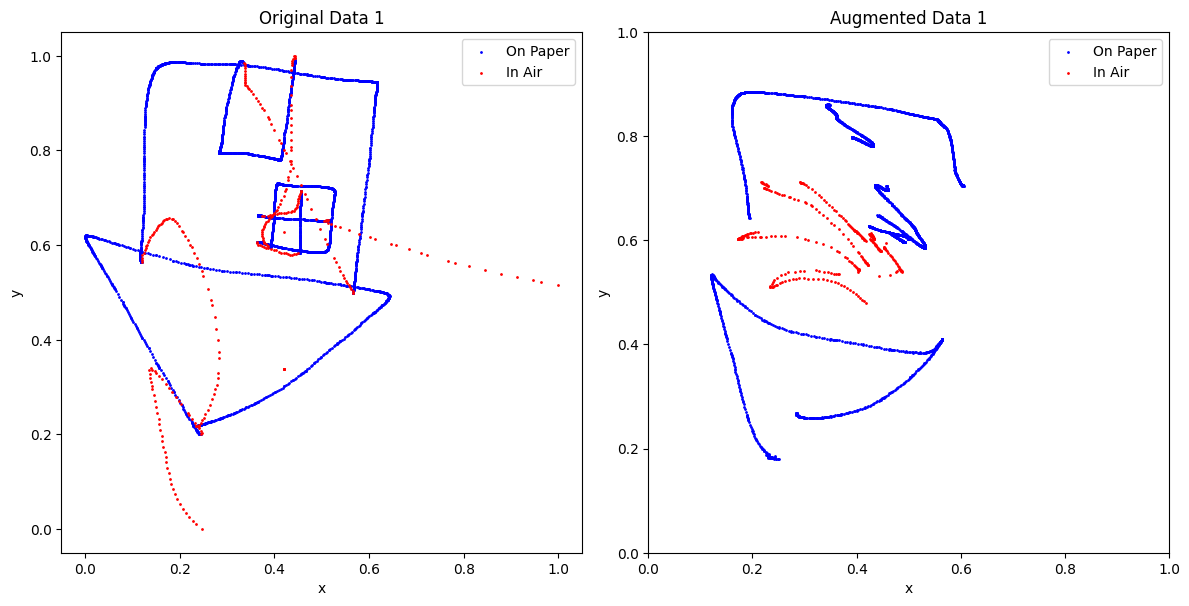

Epoch 11/200: 100%|██████████| 50/50 [00:00<00:00, 205.60batch/s, Generator Loss=0.00379, Reconstruction Loss=0.00378, KL Loss=7.26]


Epoch 11: Generator Loss = 0.004797, Reconstruction Loss = 0.004790, KL Divergence Loss = 6.924558
NRMSE = 0.245630


Epoch 12/200: 100%|██████████| 50/50 [00:00<00:00, 143.49batch/s, Generator Loss=0.00282, Reconstruction Loss=0.00282, KL Loss=7.81]


Epoch 12: Generator Loss = 0.003870, Reconstruction Loss = 0.003863, KL Divergence Loss = 7.303931
NRMSE = 0.250204


Epoch 13/200: 100%|██████████| 50/50 [00:00<00:00, 180.90batch/s, Generator Loss=0.00264, Reconstruction Loss=0.00263, KL Loss=8.1] 


Epoch 13: Generator Loss = 0.003389, Reconstruction Loss = 0.003381, KL Divergence Loss = 7.772060
NRMSE = 0.254862


Epoch 14/200: 100%|██████████| 50/50 [00:00<00:00, 204.51batch/s, Generator Loss=0.0039, Reconstruction Loss=0.0039, KL Loss=8.27]  


Epoch 14: Generator Loss = 0.002639, Reconstruction Loss = 0.002631, KL Divergence Loss = 8.349806
NRMSE = 0.258246


Epoch 15/200: 100%|██████████| 50/50 [00:00<00:00, 197.38batch/s, Generator Loss=0.00275, Reconstruction Loss=0.00274, KL Loss=8.85]


Epoch 15: Generator Loss = 0.002470, Reconstruction Loss = 0.002461, KL Divergence Loss = 8.737872
NRMSE = 0.261250


Epoch 16/200: 100%|██████████| 50/50 [00:00<00:00, 193.94batch/s, Generator Loss=0.00218, Reconstruction Loss=0.00217, KL Loss=9.08]


Epoch 16: Generator Loss = 0.002229, Reconstruction Loss = 0.002220, KL Divergence Loss = 8.859425
NRMSE = 0.265386


Epoch 17/200: 100%|██████████| 50/50 [00:00<00:00, 208.27batch/s, Generator Loss=0.00156, Reconstruction Loss=0.00156, KL Loss=8.78]


Epoch 17: Generator Loss = 0.001896, Reconstruction Loss = 0.001887, KL Divergence Loss = 9.115715
NRMSE = 0.267349


Epoch 18/200: 100%|██████████| 50/50 [00:00<00:00, 182.24batch/s, Generator Loss=0.00196, Reconstruction Loss=0.00195, KL Loss=9.55]


Epoch 18: Generator Loss = 0.001786, Reconstruction Loss = 0.001777, KL Divergence Loss = 9.303802
NRMSE = 0.268812


Epoch 19/200: 100%|██████████| 50/50 [00:00<00:00, 179.44batch/s, Generator Loss=0.0016, Reconstruction Loss=0.00159, KL Loss=9.22] 


Epoch 19: Generator Loss = 0.001685, Reconstruction Loss = 0.001675, KL Divergence Loss = 9.402164
NRMSE = 0.270049


Epoch 20/200: 100%|██████████| 50/50 [00:10<00:00,  4.90batch/s, Generator Loss=-0.138, Reconstruction Loss=0.00138, KL Loss=10]  


LSTM training at epoch 20: Discriminator Loss = [1.4020798]
Epoch 20: Generator Loss = -0.136988, Reconstruction Loss = 0.001891, KL Divergence Loss = 9.494864
NRMSE = 0.268555


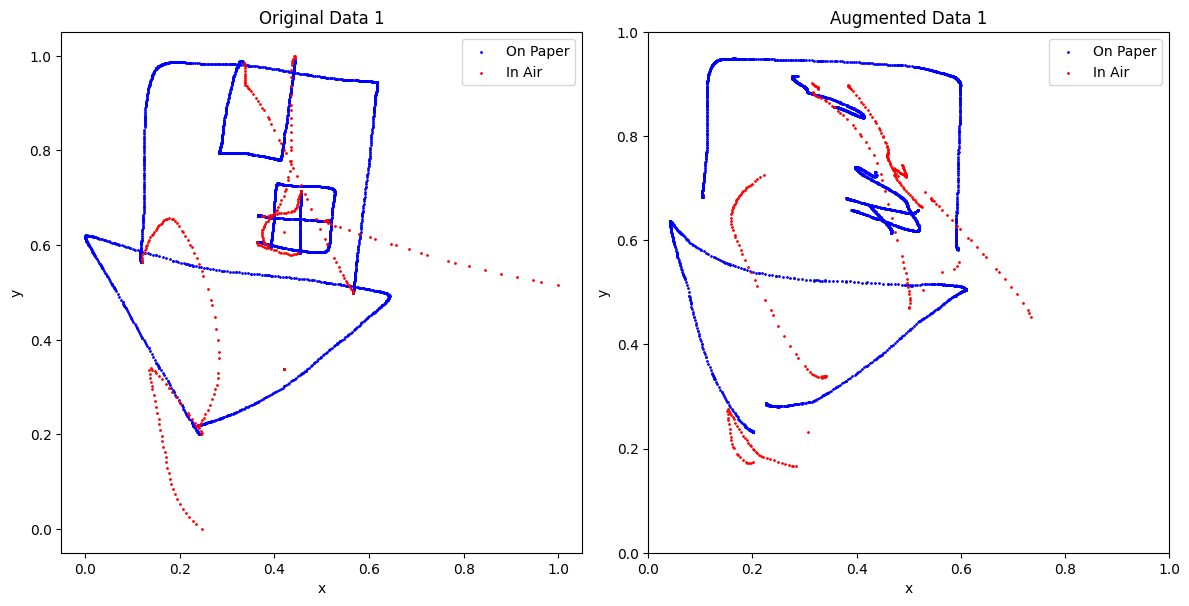

Epoch 21/200: 100%|██████████| 50/50 [00:01<00:00, 35.03batch/s, Generator Loss=-0.135, Reconstruction Loss=0.00342, KL Loss=9.55]


LSTM training at epoch 21: Discriminator Loss = [1.3680756]
Epoch 21: Generator Loss = -0.136868, Reconstruction Loss = 0.001978, KL Divergence Loss = 9.452063
NRMSE = 0.266836


Epoch 22/200: 100%|██████████| 50/50 [00:01<00:00, 36.23batch/s, Generator Loss=-0.138, Reconstruction Loss=0.00133, KL Loss=9.81] 


LSTM training at epoch 22: Discriminator Loss = [1.333147]
Epoch 22: Generator Loss = -0.137148, Reconstruction Loss = 0.001667, KL Divergence Loss = 9.263585
NRMSE = 0.269032


Epoch 23/200: 100%|██████████| 50/50 [00:01<00:00, 36.31batch/s, Generator Loss=-0.138, Reconstruction Loss=0.00111, KL Loss=9.72]


LSTM training at epoch 23: Discriminator Loss = [1.2987027]
Epoch 23: Generator Loss = -0.137437, Reconstruction Loss = 0.001448, KL Divergence Loss = 9.454146
NRMSE = 0.272373


Epoch 24/200: 100%|██████████| 50/50 [00:01<00:00, 32.93batch/s, Generator Loss=-0.137, Reconstruction Loss=0.00168, KL Loss=9.6]  


LSTM training at epoch 24: Discriminator Loss = [1.2653573]
Epoch 24: Generator Loss = -0.137526, Reconstruction Loss = 0.001534, KL Divergence Loss = 9.476431
NRMSE = 0.270230


Epoch 25/200: 100%|██████████| 50/50 [00:01<00:00, 28.83batch/s, Generator Loss=-0.138, Reconstruction Loss=0.00137, KL Loss=9.87] 


LSTM training at epoch 25: Discriminator Loss = [1.22599]
Epoch 25: Generator Loss = -0.137825, Reconstruction Loss = 0.001479, KL Divergence Loss = 9.613664
NRMSE = 0.270908


Epoch 26/200: 100%|██████████| 50/50 [00:01<00:00, 32.68batch/s, Generator Loss=-0.138, Reconstruction Loss=0.0013, KL Loss=9.54]  


LSTM training at epoch 26: Discriminator Loss = [1.1739422]
Epoch 26: Generator Loss = -0.138329, Reconstruction Loss = 0.001563, KL Divergence Loss = 9.583227
NRMSE = 0.272873


Epoch 27/200: 100%|██████████| 50/50 [00:01<00:00, 31.33batch/s, Generator Loss=-0.139, Reconstruction Loss=0.00221, KL Loss=9]    


LSTM training at epoch 27: Discriminator Loss = [1.1206628]
Epoch 27: Generator Loss = -0.138825, Reconstruction Loss = 0.001804, KL Divergence Loss = 9.556209
NRMSE = 0.273276


Epoch 28/200: 100%|██████████| 50/50 [00:01<00:00, 35.47batch/s, Generator Loss=-0.141, Reconstruction Loss=0.00194, KL Loss=8.59] 


LSTM training at epoch 28: Discriminator Loss = [1.0617487]
Epoch 28: Generator Loss = -0.140647, Reconstruction Loss = 0.001649, KL Divergence Loss = 9.467678
NRMSE = 0.273956


Epoch 29/200: 100%|██████████| 50/50 [00:01<00:00, 32.34batch/s, Generator Loss=-0.143, Reconstruction Loss=0.00122, KL Loss=9.28]


LSTM training at epoch 29: Discriminator Loss = [0.99967694]
Epoch 29: Generator Loss = -0.143730, Reconstruction Loss = 0.001681, KL Divergence Loss = 9.424046
NRMSE = 0.274249


Epoch 30/200: 100%|██████████| 50/50 [00:01<00:00, 33.94batch/s, Generator Loss=-0.152, Reconstruction Loss=0.00206, KL Loss=9.76]


LSTM training at epoch 30: Discriminator Loss = [0.94386345]
Epoch 30: Generator Loss = -0.149341, Reconstruction Loss = 0.001613, KL Divergence Loss = 9.331296
NRMSE = 0.275987


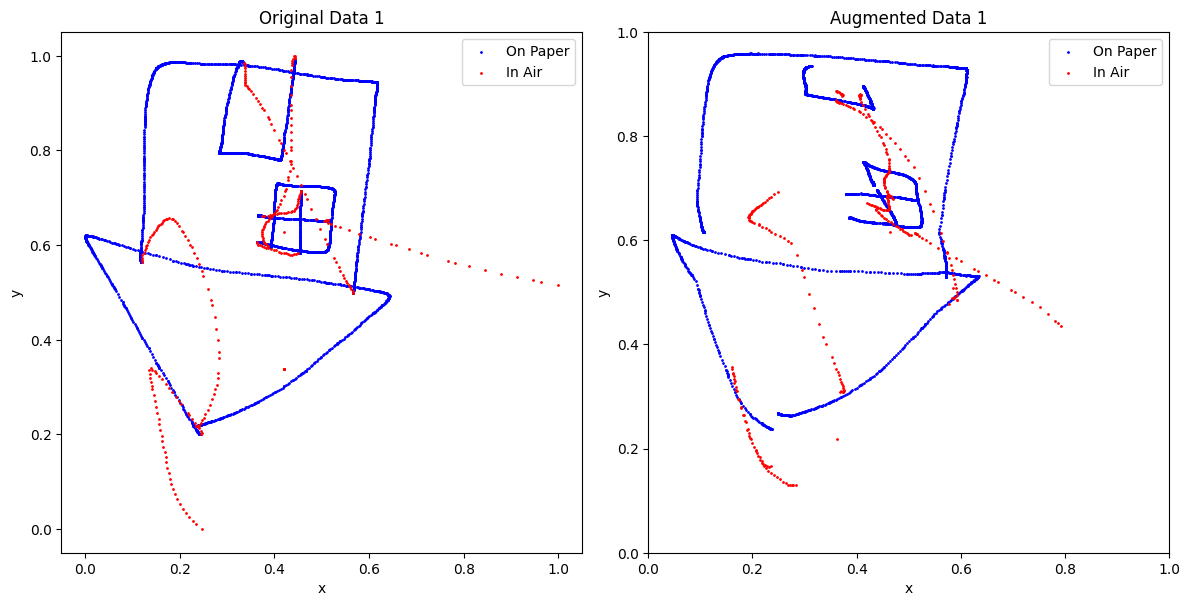

Epoch 31/200: 100%|██████████| 50/50 [00:01<00:00, 36.17batch/s, Generator Loss=-0.159, Reconstruction Loss=0.000707, KL Loss=8.94]


LSTM training at epoch 31: Discriminator Loss = [0.80737007]
Epoch 31: Generator Loss = -0.157751, Reconstruction Loss = 0.001155, KL Divergence Loss = 9.219152
NRMSE = 0.276154


Epoch 32/200: 100%|██████████| 50/50 [00:01<00:00, 35.80batch/s, Generator Loss=-0.166, Reconstruction Loss=0.000881, KL Loss=8.9] 


LSTM training at epoch 32: Discriminator Loss = [0.70310646]
Epoch 32: Generator Loss = -0.169146, Reconstruction Loss = 0.000918, KL Divergence Loss = 9.351053
NRMSE = 0.276333


Epoch 33/200: 100%|██████████| 50/50 [00:01<00:00, 38.44batch/s, Generator Loss=-0.181, Reconstruction Loss=0.000768, KL Loss=9.78]


LSTM training at epoch 33: Discriminator Loss = [0.62930363]
Epoch 33: Generator Loss = -0.181001, Reconstruction Loss = 0.000980, KL Divergence Loss = 9.285986
NRMSE = 0.276961


Epoch 34/200: 100%|██████████| 50/50 [00:01<00:00, 35.25batch/s, Generator Loss=-0.194, Reconstruction Loss=0.000628, KL Loss=9]   


LSTM training at epoch 34: Discriminator Loss = [0.52379507]
Epoch 34: Generator Loss = -0.193597, Reconstruction Loss = 0.000707, KL Divergence Loss = 9.300921
NRMSE = 0.278343


Epoch 35/200: 100%|██████████| 50/50 [00:01<00:00, 37.70batch/s, Generator Loss=-0.205, Reconstruction Loss=0.000568, KL Loss=9.36]


LSTM training at epoch 35: Discriminator Loss = [0.43794382]
Epoch 35: Generator Loss = -0.202438, Reconstruction Loss = 0.000755, KL Divergence Loss = 9.339702
NRMSE = 0.276948


Epoch 36/200: 100%|██████████| 50/50 [00:01<00:00, 38.81batch/s, Generator Loss=-0.215, Reconstruction Loss=0.000457, KL Loss=9.34]


LSTM training at epoch 36: Discriminator Loss = [0.36960137]
Epoch 36: Generator Loss = -0.210951, Reconstruction Loss = 0.000713, KL Divergence Loss = 9.330684
NRMSE = 0.277585


Epoch 37/200: 100%|██████████| 50/50 [00:01<00:00, 38.05batch/s, Generator Loss=-0.219, Reconstruction Loss=0.000574, KL Loss=8.65]


LSTM training at epoch 37: Discriminator Loss = [0.29580027]
Epoch 37: Generator Loss = -0.219637, Reconstruction Loss = 0.000588, KL Divergence Loss = 9.279132
NRMSE = 0.277897


Epoch 38/200: 100%|██████████| 50/50 [00:01<00:00, 35.71batch/s, Generator Loss=-0.23, Reconstruction Loss=0.000404, KL Loss=10]   


LSTM training at epoch 38: Discriminator Loss = [0.26404965]
Epoch 38: Generator Loss = -0.228155, Reconstruction Loss = 0.000593, KL Divergence Loss = 9.386383
NRMSE = 0.277871


Epoch 39/200: 100%|██████████| 50/50 [00:01<00:00, 37.95batch/s, Generator Loss=-0.238, Reconstruction Loss=0.000251, KL Loss=9.21]


LSTM training at epoch 39: Discriminator Loss = [0.22976796]
Epoch 39: Generator Loss = -0.237537, Reconstruction Loss = 0.000479, KL Divergence Loss = 9.435429
NRMSE = 0.279222


Epoch 40/200: 100%|██████████| 50/50 [00:01<00:00, 33.18batch/s, Generator Loss=-0.248, Reconstruction Loss=0.000394, KL Loss=9.5] 


LSTM training at epoch 40: Discriminator Loss = [0.18620424]
Epoch 40: Generator Loss = -0.247309, Reconstruction Loss = 0.000458, KL Divergence Loss = 9.491071
NRMSE = 0.279394


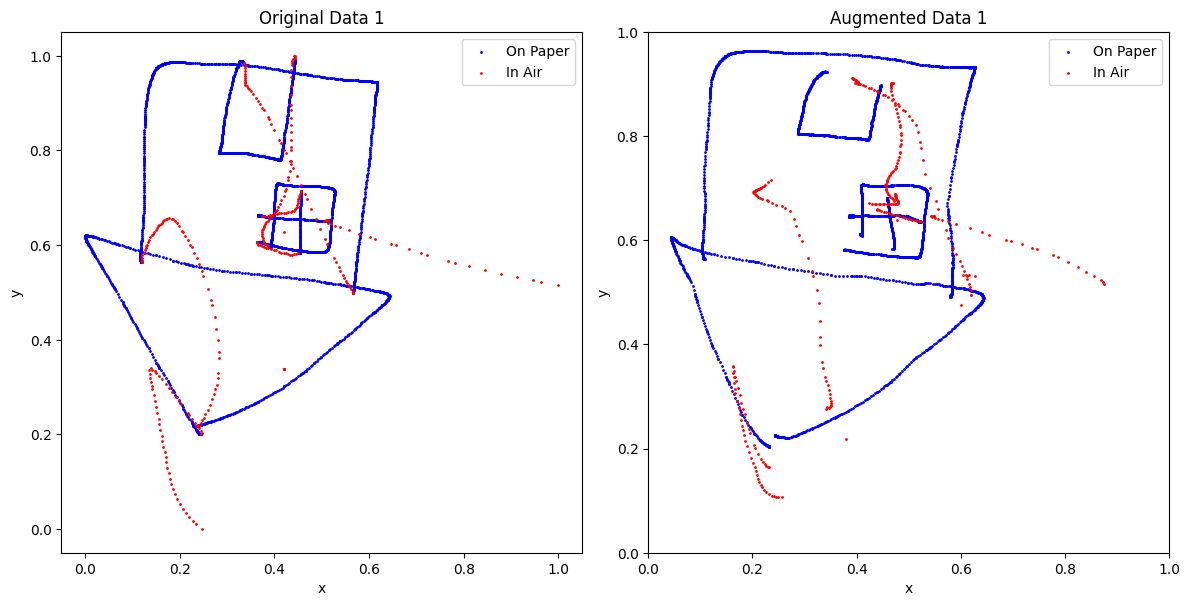

Epoch 41/200: 100%|██████████| 50/50 [00:01<00:00, 37.86batch/s, Generator Loss=-0.257, Reconstruction Loss=0.000271, KL Loss=8.88]


LSTM training at epoch 41: Discriminator Loss = [0.16402313]
Epoch 41: Generator Loss = -0.255958, Reconstruction Loss = 0.000444, KL Divergence Loss = 9.470392
NRMSE = 0.281237


Epoch 42/200: 100%|██████████| 50/50 [00:01<00:00, 37.12batch/s, Generator Loss=-0.263, Reconstruction Loss=0.000391, KL Loss=9.45]


LSTM training at epoch 42: Discriminator Loss = [0.14513427]
Epoch 42: Generator Loss = -0.263190, Reconstruction Loss = 0.000415, KL Divergence Loss = 9.528818
NRMSE = 0.281969


Epoch 43/200: 100%|██████████| 50/50 [00:01<00:00, 37.28batch/s, Generator Loss=-0.27, Reconstruction Loss=0.000353, KL Loss=8.9]  


LSTM training at epoch 43: Discriminator Loss = [0.13253134]
Epoch 43: Generator Loss = -0.269776, Reconstruction Loss = 0.000418, KL Divergence Loss = 9.553829
NRMSE = 0.284563


Epoch 44/200: 100%|██████████| 50/50 [00:01<00:00, 36.64batch/s, Generator Loss=-0.275, Reconstruction Loss=0.00061, KL Loss=9.24] 


LSTM training at epoch 44: Discriminator Loss = [0.12208192]
Epoch 44: Generator Loss = -0.275583, Reconstruction Loss = 0.000402, KL Divergence Loss = 9.566357
NRMSE = 0.281932


Epoch 45/200: 100%|██████████| 50/50 [00:01<00:00, 35.42batch/s, Generator Loss=-0.281, Reconstruction Loss=0.000269, KL Loss=10.1]


LSTM training at epoch 45: Discriminator Loss = [3.0912144]
Epoch 45: Generator Loss = -0.281132, Reconstruction Loss = 0.000337, KL Divergence Loss = 9.567692
NRMSE = 0.281128


Epoch 46/200: 100%|██████████| 50/50 [00:01<00:00, 35.84batch/s, Generator Loss=-0.287, Reconstruction Loss=0.000233, KL Loss=9.49]


LSTM training at epoch 46: Discriminator Loss = [0.11142145]
Epoch 46: Generator Loss = -0.286427, Reconstruction Loss = 0.000318, KL Divergence Loss = 9.672717
NRMSE = 0.282295


Epoch 47/200: 100%|██████████| 50/50 [00:01<00:00, 33.37batch/s, Generator Loss=-0.292, Reconstruction Loss=0.000549, KL Loss=9.69]


LSTM training at epoch 47: Discriminator Loss = [0.10868801]
Epoch 47: Generator Loss = -0.291937, Reconstruction Loss = 0.000277, KL Divergence Loss = 9.745642
NRMSE = 0.282931


Epoch 48/200: 100%|██████████| 50/50 [00:01<00:00, 35.83batch/s, Generator Loss=-0.297, Reconstruction Loss=0.000391, KL Loss=10.3]


LSTM training at epoch 48: Discriminator Loss = [2.9124663]
Epoch 48: Generator Loss = -0.297141, Reconstruction Loss = 0.000322, KL Divergence Loss = 9.828196
NRMSE = 0.280853


Epoch 49/200: 100%|██████████| 50/50 [00:01<00:00, 35.92batch/s, Generator Loss=-0.296, Reconstruction Loss=0.000315, KL Loss=8.84]


LSTM training at epoch 49: Discriminator Loss = [0.10746843]
Epoch 49: Generator Loss = -0.296868, Reconstruction Loss = 0.000343, KL Divergence Loss = 9.767972
NRMSE = 0.282294


Epoch 50/200: 100%|██████████| 50/50 [00:01<00:00, 36.41batch/s, Generator Loss=-0.369, Reconstruction Loss=0.222, KL Loss=12.5]   


LSTM training at epoch 50: Discriminator Loss = [3.0418]
Epoch 50: Generator Loss = -0.314755, Reconstruction Loss = 0.105353, KL Divergence Loss = 11.030891
NRMSE = 0.217628


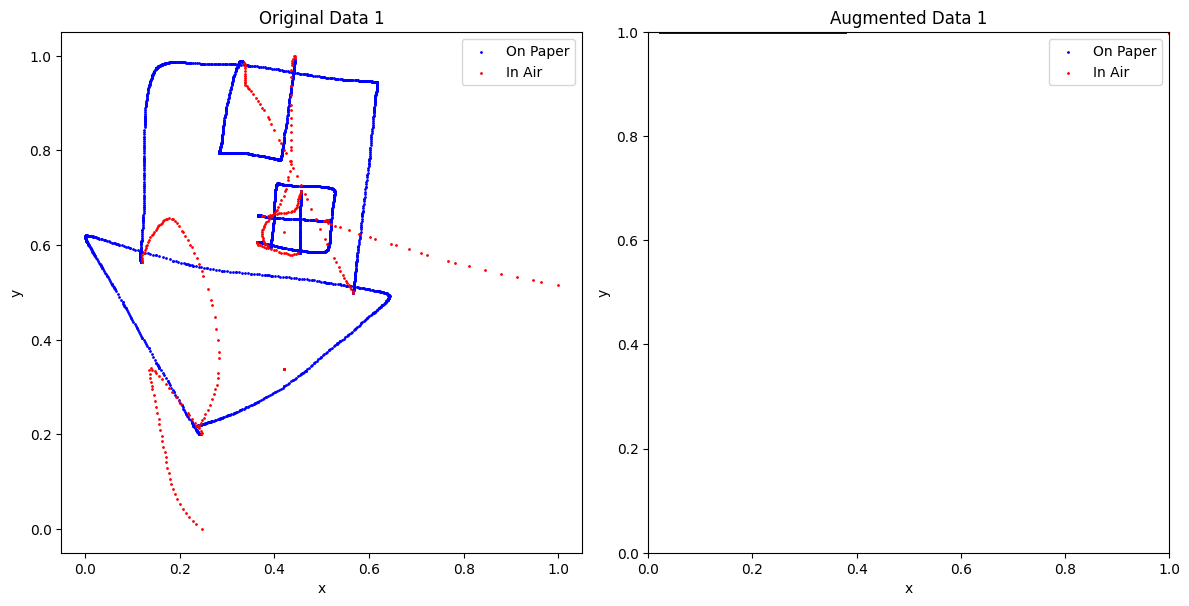

Epoch 51/200: 100%|██████████| 50/50 [00:01<00:00, 36.12batch/s, Generator Loss=-0.381, Reconstruction Loss=0.206, KL Loss=11.8]


LSTM training at epoch 51: Discriminator Loss = [2.995694]
Epoch 51: Generator Loss = -0.396157, Reconstruction Loss = 0.190642, KL Divergence Loss = 12.606398
NRMSE = 0.225934


Epoch 52/200: 100%|██████████| 50/50 [00:01<00:00, 27.95batch/s, Generator Loss=-0.416, Reconstruction Loss=0.165, KL Loss=11.8]


LSTM training at epoch 52: Discriminator Loss = [2.9293869]
Epoch 52: Generator Loss = -0.387039, Reconstruction Loss = 0.188479, KL Divergence Loss = 12.221165
NRMSE = 0.225573


Epoch 53/200: 100%|██████████| 50/50 [00:01<00:00, 29.19batch/s, Generator Loss=-0.377, Reconstruction Loss=0.196, KL Loss=12.2] 


LSTM training at epoch 53: Discriminator Loss = [2.852052]
Epoch 53: Generator Loss = -0.373528, Reconstruction Loss = 0.188476, KL Divergence Loss = 12.246102
NRMSE = 0.225529


Epoch 54/200: 100%|██████████| 50/50 [00:02<00:00, 23.79batch/s, Generator Loss=-0.375, Reconstruction Loss=0.19, KL Loss=12.5] 


LSTM training at epoch 54: Discriminator Loss = [2.7563708]
Epoch 54: Generator Loss = -0.370556, Reconstruction Loss = 0.188469, KL Divergence Loss = 12.267262
NRMSE = 0.224113


Epoch 55/200: 100%|██████████| 50/50 [00:02<00:00, 24.73batch/s, Generator Loss=-0.336, Reconstruction Loss=0.219, KL Loss=11.8] 


KeyboardInterrupt: 

In [6]:
# Cell 5
@tf.function
def train_vae_step(model, x, optimizer, lstm_discriminator=None):
    with tf.GradientTape() as tape:
        x_reconstructed, mean, logvar = model(x)
        reconstruction_loss, kl_loss, total_kl_loss = compute_loss(model, x)
        
        # Add LSTM discriminator loss if available
        if lstm_discriminator is not None:
            real_predictions = lstm_discriminator(tf.expand_dims(x, axis=0))
            fake_predictions = lstm_discriminator(tf.expand_dims(x_reconstructed, axis=0))
            discriminator_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.ones_like(real_predictions), real_predictions) +
                                                tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_predictions), fake_predictions))
            generator_loss = reconstruction_loss + total_kl_loss - 0.1 * discriminator_loss  # Adjust the weight as needed
        else:
            generator_loss = reconstruction_loss + total_kl_loss
    
    gradients = tape.gradient(generator_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return generator_loss, reconstruction_loss, kl_loss

@tf.function
def train_lstm_step(lstm_model, real_data, generated_data, optimizer):
    with tf.GradientTape() as tape:
        real_predictions = lstm_model(real_data)
        generated_predictions = lstm_model(generated_data)
        real_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(real_predictions), real_predictions)
        generated_loss = tf.keras.losses.binary_crossentropy(tf.zeros_like(generated_predictions), generated_predictions)
        total_loss = real_loss + generated_loss
    gradients = tape.gradient(total_loss, lstm_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, lstm_model.trainable_variables))
    return total_loss

# Initialize LSTM discriminator and optimizer
lstm_discriminator = LSTMDiscriminator()
lstm_optimizer = tf.keras.optimizers.Adam(learning_rate)

batch_size = 64
train_datasets = [tf.data.Dataset.from_tensor_slices(data).shuffle(10000).batch(batch_size) for data in processed_data]

# Set up alternating epochs
vae_epochs = 19
lstm_interval = 1
epochs = 200

generator_loss_history = []
reconstruction_loss_history = []
kl_loss_history = []
nrmse_history = []

for epoch in range(epochs):
    generator_loss = 0 
    reconstruction_loss_sum = 0
    kl_loss_sum = 0
    num_batches = sum(len(dataset) for dataset in train_datasets)

    with tqdm(total=num_batches, desc=f'Epoch {epoch+1}/{epochs}', unit='batch') as pbar:
        for dataset in train_datasets:
            for batch in dataset:
                # Use LSTM discriminator after vae_epochs and every lstm_interval
                use_lstm = epoch >= vae_epochs and (epoch - vae_epochs) % lstm_interval == 0
                generator_loss_batch, reconstruction_loss, kl_loss = train_vae_step(vae, batch, optimizer, lstm_discriminator if use_lstm else None)
                generator_loss += generator_loss_batch
                reconstruction_loss_sum += reconstruction_loss
                kl_loss_sum += kl_loss
                pbar.update(1)
                pbar.set_postfix({'Generator Loss': float(generator_loss_batch), 'Reconstruction Loss': float(reconstruction_loss), 'KL Loss': float(kl_loss)})

    # Train the LSTM discriminator every lstm_interval epochs after vae_epochs
    if epoch >= vae_epochs and (epoch - vae_epochs) % lstm_interval == 0:
        for data in processed_data:
            augmented_data = vae.decode(tf.random.normal(shape=(data.shape[0], latent_dim))).numpy()
            real_data = tf.expand_dims(data, axis=0)  # Reshape for LSTM input
            generated_data = tf.expand_dims(augmented_data, axis=0)

            lstm_loss = train_lstm_step(lstm_discriminator, real_data, generated_data, lstm_optimizer)
        print(f'LSTM training at epoch {epoch+1}: Discriminator Loss = {lstm_loss.numpy()}')

    avg_generator_loss = generator_loss / num_batches  # Update the average calculation
    avg_reconstruction_loss = reconstruction_loss_sum / num_batches
    avg_kl_loss = kl_loss_sum / num_batches

    generator_loss_history.append(avg_generator_loss)  # Update history list
    reconstruction_loss_history.append(avg_reconstruction_loss)
    kl_loss_history.append(avg_kl_loss)

    # Calculate NRMSE
    nrmse_sum = 0
    for data in processed_data:
        augmented_data = vae.decode(tf.random.normal(shape=(data.shape[0], latent_dim))).numpy()
        rmse = np.sqrt(mean_squared_error(data[:, :2], augmented_data[:, :2]))
        nrmse = rmse / (data[:, :2].max() - data[:, :2].min())
        nrmse_sum += nrmse
    
    nrmse_avg = nrmse_sum / len(processed_data)

    nrmse_history.append(nrmse_avg)

    print(f"Epoch {epoch+1}: Generator Loss = {avg_generator_loss:.6f}, Reconstruction Loss = {avg_reconstruction_loss:.6f}, KL Divergence Loss = {avg_kl_loss:.6f}")
    print(f"NRMSE = {nrmse_avg:.6f}")

    if (epoch + 1) % 10 == 0:
        num_augmented_files = 1  # You can change this number as needed
        augmented_datasets = generate_augmented_data(vae, num_augmented_files, avg_data_points, processed_data, latent_variability=100.0)

        # Visualize the original and augmented data side by side
        fig, axs = plt.subplots(1, num_augmented_files + len(processed_data), figsize=(6*(num_augmented_files + len(processed_data)), 6))
        
        for i, original_data in enumerate(processed_data):
            original_on_paper = original_data[original_data[:, 3] == 1]
            original_in_air = original_data[original_data[:, 3] == 0]
            axs[i].scatter(original_on_paper[:, 0], original_on_paper[:, 1], c='b', s=1, label='On Paper')
            axs[i].scatter(original_in_air[:, 0], original_in_air[:, 1], c='r', s=1, label='In Air')
            axs[i].set_title(f'Original Data {i+1}')
            axs[i].set_xlabel('x')
            axs[i].set_ylabel('y')
            axs[i].set_aspect('equal')
            axs[i].legend()

        # Set consistent axis limits for square aspect ratio
        x_min = min(data[:, 0].min() for data in processed_data)
        x_max = max(data[:, 0].max() for data in processed_data)
        y_min = min(data[:, 1].min() for data in processed_data)
        y_max = max(data[:, 1].max() for data in processed_data)

        for i, augmented_data in enumerate(augmented_datasets):
            augmented_on_paper = augmented_data[augmented_data[:, 3] == 1]
            augmented_in_air = augmented_data[augmented_data[:, 3] == 0]
            axs[i+len(processed_data)].scatter(augmented_on_paper[:, 0], augmented_on_paper[:, 1], c='b', s=1, label='On Paper')
            axs[i+len(processed_data)].scatter(augmented_in_air[:, 0], augmented_in_air[:, 1], c='r', s=1, label='In Air')
            axs[i+len(processed_data)].set_title(f'Augmented Data {i+1}')
            axs[i+len(processed_data)].set_xlabel('x')
            axs[i+len(processed_data)].set_ylabel('y')
            axs[i+len(processed_data)].set_aspect('equal')
            axs[i+len(processed_data)].set_xlim(x_min, x_max)
            axs[i+len(processed_data)].set_ylim(y_min, y_max)
            axs[i+len(processed_data)].legend()

        plt.tight_layout()
        plt.show()

# Final output of metrics
print(f"Final NRMSE: {nrmse_history[-1]:.6f}")

print("Training completed.")
plt.ioff()  # Turn off interactive mode
plt.show()

# Plot generator loss history
plt.figure(figsize=(10, 5))
plt.plot(generator_loss_history, label='Generator Loss')  # Update label
plt.plot(reconstruction_loss_history, label='Reconstruction Loss')
plt.plot(kl_loss_history, label='KL Divergence Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

# Plot NRMSE history
plt.subplot(1, 3, 3)
plt.plot(nrmse_history, label='NRMSE')
plt.xlabel('Epoch')
plt.ylabel('NRMSE')
plt.title('Normalized Root Mean Squared Error Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [49]:
# Cell 6
def download_augmented_data(augmented_datasets, scaler, directory='augmented_data'):
    if not os.path.exists(directory):
        os.makedirs(directory)

    for i, augmented_data in enumerate(augmented_datasets):
        augmented_data_original_scale = np.column_stack((
            scaler.inverse_transform(augmented_data[:, :3]),  # Inverse scale x, y, timestamp
            augmented_data[:, 3]  # Keep pen_status unchanged
        ))

        # Save each augmented dataset to a CSV file
        filename = os.path.join(directory, f'augmented_data_{i+1}.csv')
        pd.DataFrame(augmented_data_original_scale, columns=['x', 'y', 'timestamp', 'pen_status']).to_csv(filename, index=False)
        print(f"Saved {filename}")

# Call the updated function with the same scaler for all augmented datasets
download_augmented_data(augmented_datasets, scalers[0])


Saved augmented_data\augmented_data_1.csv


C:\Users\annek\AppData\Roaming\Python\Python312\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


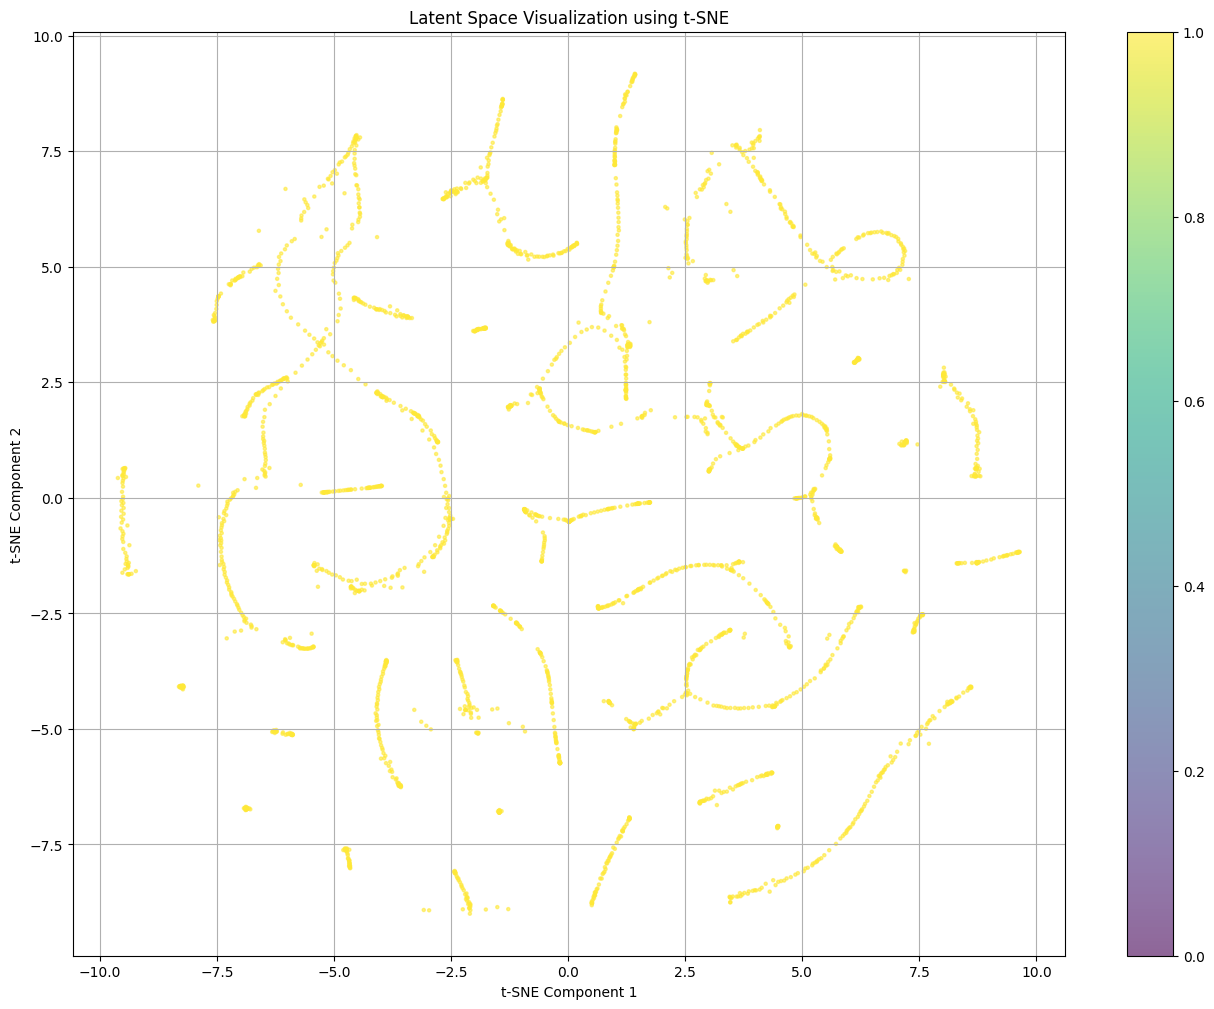

In [117]:
#Cell 7 Function to visualize the latent space with a color gradient
def visualize_latent_space(model, data, perplexity=5, learning_rate=200, n_iter=250):
    # Encode data into the latent space
    latent_means, _ = model.encode(tf.convert_to_tensor(data, dtype=tf.float32))
    latent_means_np = latent_means.numpy()
    
    # Use t-SNE to reduce dimensionality to 2D
    tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, n_iter=n_iter)
    latent_2d = tsne.fit_transform(latent_means_np)
    
    # Create a color map for the latent points
    norm = plt.Normalize(vmin=np.min(latent_means_np), vmax=np.max(latent_means_np))
    cmap = plt.cm.cividis  # You can change the colormap to 'plasma', 'inferno', etc.
    colors = cmap(norm(latent_means_np).sum(axis=1))  # Coloring based on the sum of latent variables
    
    # Plot the 2D t-SNE result with the color map
    plt.figure(figsize=(16, 12))
    scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=colors, s=5, alpha=0.6)
    plt.colorbar(scatter)  # Add a color bar for the gradient
    plt.title('Latent Space Visualization using t-SNE')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.grid(True)
    plt.show()

# Visualize latent space for one of the processed datasets
visualize_latent_space(vae, processed_data[0])